Import libs

In [ ]:
# import libs
import glob, pylab, pandas as pd
import pydicom, numpy as np
import random
import json
import time
import copy
import pydicom
import torchvision
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from pathlib import Path

# from fastai.conv_learner import *
# from fastai.dataset import *
# from fastai.dataset import ImageClassifierData

In [ ]:
# see input dir
!ls ../input

In [ ]:
PATH = Path('../input')
# read training lables
train_bb_df = pd.read_csv(PATH/'stage_1_train_labels.csv')
train_bb_df.head()

row 4 shows, there is bouding box in image with given x & y. First 4 image don't have any bounding box
### check if duplicate bounding box are present for any patient

In [ ]:
train_bb_df['duplicate'] = train_bb_df.duplicated(['patientId'], keep=False)
# see data
train_bb_df[train_bb_df['duplicate']].head()

In [ ]:
detailed_df = pd.read_csv(PATH/'stage_1_detailed_class_info.csv')
# merge two df
class_df = train_bb_df.merge(detailed_df, on="patientId")
# class_df.head()
csv_df = class_df.filter(['patientId', 'Target'], )
csv_df = csv_df.set_index('patientId', )
# detailed_df.head() , 
class_df.head(10)
# csv_df.head()

In [ ]:
# these are dcm image files. Lets load them
# ! ls {PATH}'/stage_1_test_images' | head

Loading all train images in memory causes memory overflow. Kernel will restart. 
We creating dataset to read images, then apply transformation.

In [ ]:
class CDataset(Dataset):
    def __init__(self, ds, img_dir, class_df, transform=None, ext=None): 
        self.ds = ds
        self.img_dir = img_dir
        self.class_df = class_df
        self.ext = ext or '.dcm'
        self.transform = transforms.Compose(transform) if transform else None
        
    def __len__(self): 
        return len(self.ds)
    
    def read_dicom_image(self, loc):
        # return numpy array
        img_arr = pydicom.read_file(loc.as_posix()).pixel_array
        img_arr = img_arr/img_arr.max()
        img_arr = (255*img_arr).clip(0, 255).astype(np.uint8)
        img_arr = Image.fromarray(img_arr).convert('RGB') # model expects 3 channel image
        return img_arr
        
    def __getitem__(self, i):
        img = self.read_dicom_image(self.ds[i])
        if self.transform:
            img = self.transform(img)
        patientId = self.ds[i].name.split('.')[0]
        kls = self.class_df[self.class_df['patientId'] == patientId]
        return img, kls.iloc[0].Target

We are randomly sampling 400 images. This for testing our code.

In [ ]:
# img_dir = PATH/'stage_1_train_images'
img_dir = PATH/'stage_1_train_images'
sample = random.sample(list(img_dir.iterdir()), 400) # sample
# sample = list(img_dir.iterdir())
train, test = train_test_split(sample)

transform = [transforms.Resize(224), transforms.RandomHorizontalFlip() , transforms.ToTensor()]
train_ds = CDataset(train, img_dir, class_df, transform=transform)
test_ds = CDataset(test, img_dir, class_df, transform=transform)

In [ ]:
batch_size=32
sz=224
train_dl = DataLoader(train_ds, batch_size=batch_size,)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
def show_img(im, figsize=None, ax=None):
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
  o.set_path_effects([patheffects.Stroke(
      linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
image, klass = next(iter(train_dl))
fig, axes = plt.subplots(1, 4, figsize=(12, 2))
for i,ax in enumerate(axes.flat):
    image, klass
#     ima=image[i].numpy().transpose((1, 2, 0))
    ima=image[i][0]
    b = klass[i]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)

plt.tight_layout()

In [ ]:
use_gpu = torch.cuda.is_available()
dataloaders = {'train': train_dl, 'val':test_dl}
               
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            data_loader = dataloaders[phase]
            for data in data_loader:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(),requires_grad=True)
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
device = torch.cuda.set_device(0)

model_ft = torchvision.models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
since = time.time()

Lets train our model and check classification accuracy

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

In [ ]:
! nvidia-smi 

1. With resnet 18, transformation.RandomResizedCrop(224) & random sample of 400 images we reached to 85%
1. With resnet18, only horizontal flip transformation & random sample of 400 images we reached to 84%
1. 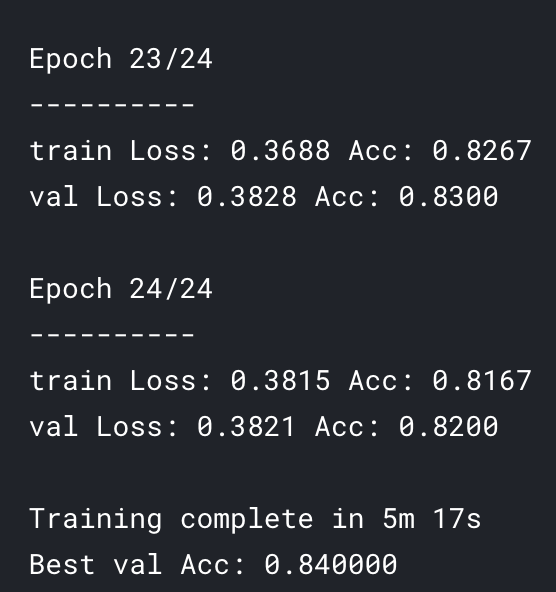
1. With resnet18, Adam optimizer, val loss reduces to 85%